In [2]:
#5

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


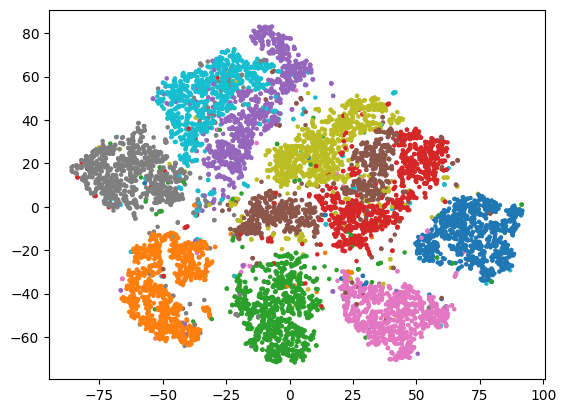

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


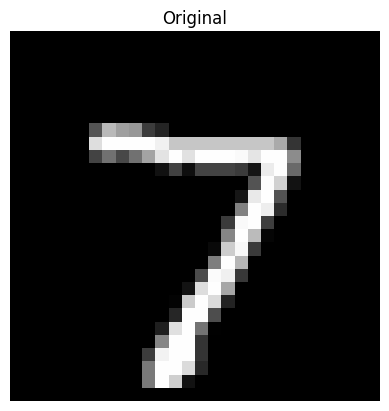

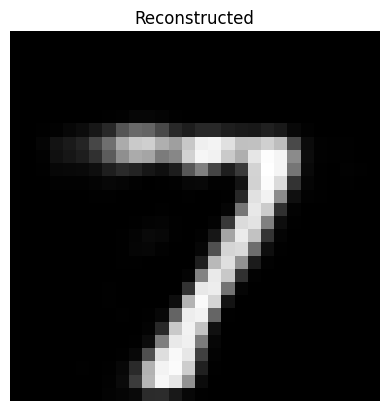

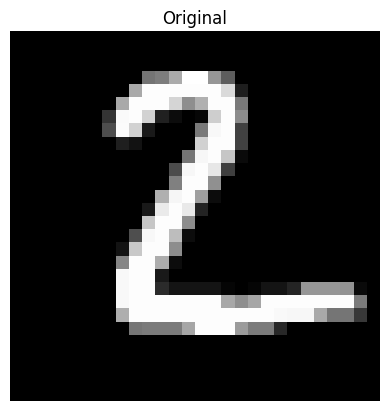

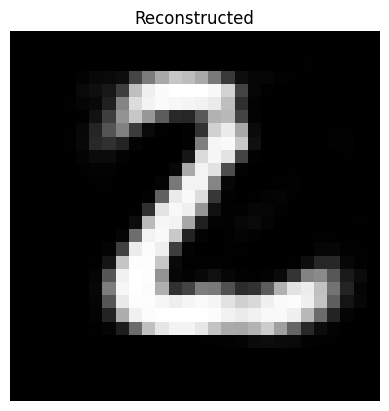

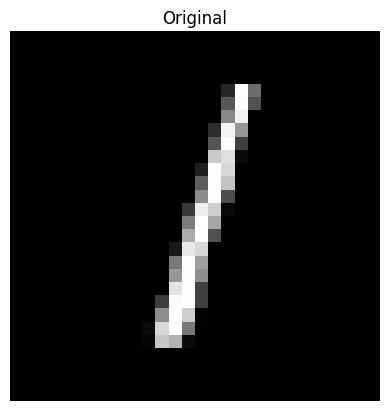

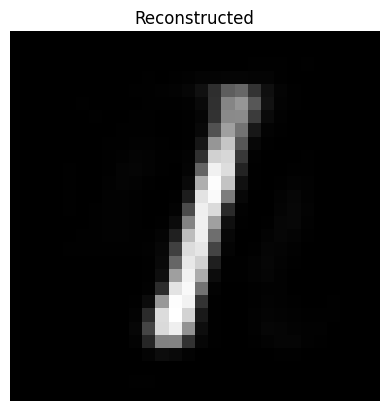

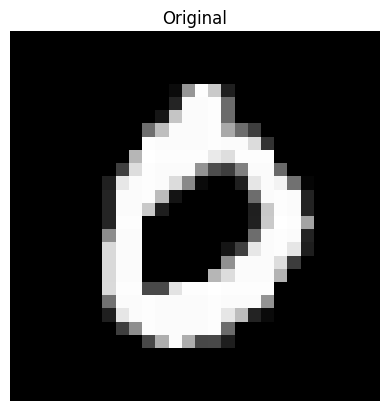

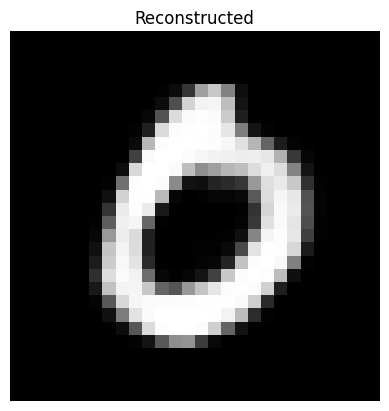

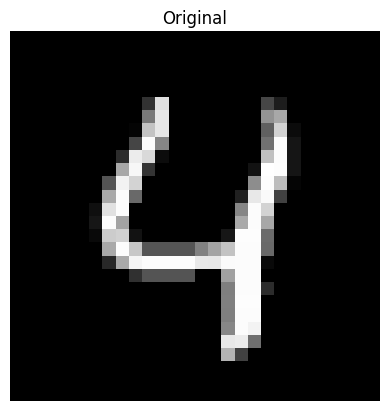

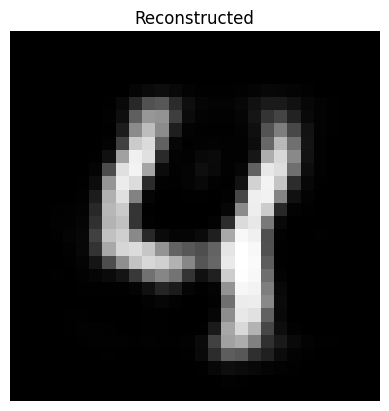

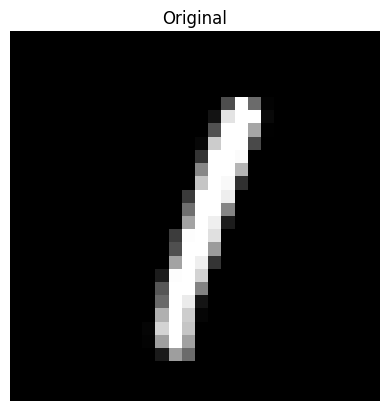

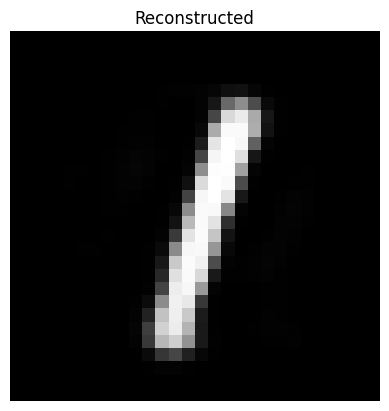

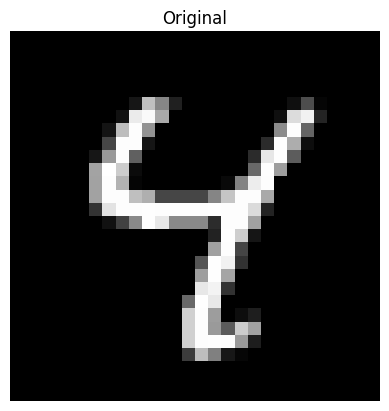

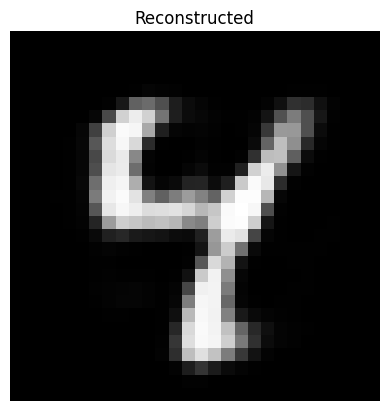

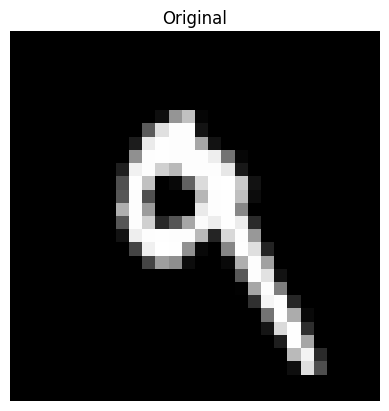

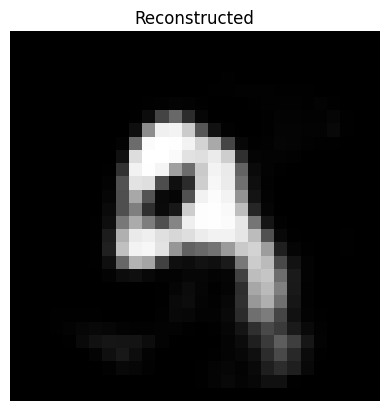

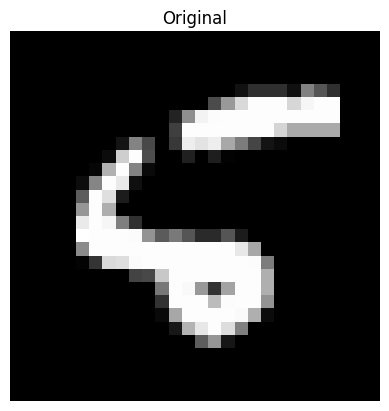

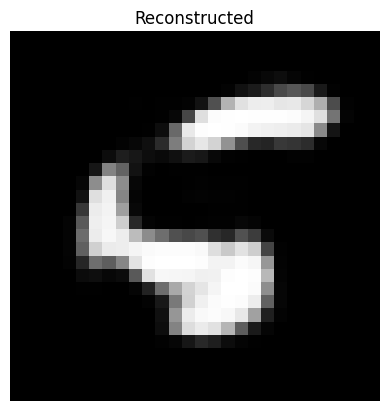

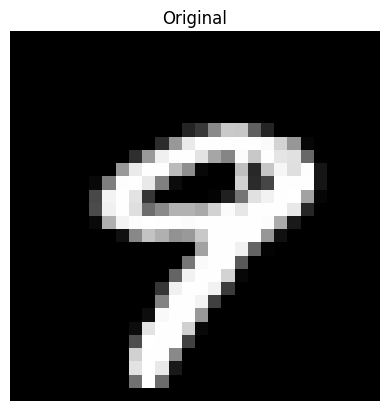

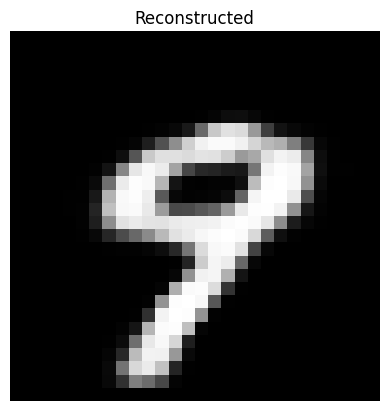

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.manifold import TSNE

(x_train,_),(x_test,y_test)=mnist.load_data()
x_train,x_test=x_train.reshape(-1,784)/255.,x_test.reshape(-1,784)/255.

inp=Input((784,))
enc=Dense(32,activation='relu')(inp)
dec=Dense(784,activation='sigmoid')(enc)
auto=Model(inp,dec);enc_model=Model(inp,enc)
auto.compile('adam','binary_crossentropy')
auto.fit(x_train,x_train,epochs=10,batch_size=256,verbose=0)

enc_test=enc_model.predict(x_test)
X2d=TSNE(2,random_state=0).fit_transform(enc_test)
plt.scatter(X2d[:,0],X2d[:,1],c=y_test,cmap="tab10",s=5);plt.show()

dec_test=auto.predict(x_test[:10])
for i in range(10):
    plt.imshow(x_test[i].reshape(28,28),cmap="gray");plt.title("Original");plt.axis('off');plt.show()
    plt.imshow(dec_test[i].reshape(28,28),cmap="gray");plt.title("Reconstructed");plt.axis('off');plt.show()


In [3]:
#4

Epoch 1/2
372/372 ━━━━━━━━━━━━━━━━━━━━ 161s 408ms/step - accuracy: 0.3907 - loss: 1.7759 - val_accuracy: 0.5511 - val_loss: 1.4041
Epoch 2/2
372/372 ━━━━━━━━━━━━━━━━━━━━ 136s 365ms/step - accuracy: 0.5854 - loss: 1.3062 - val_accuracy: 0.6260 - val_loss: 1.2159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


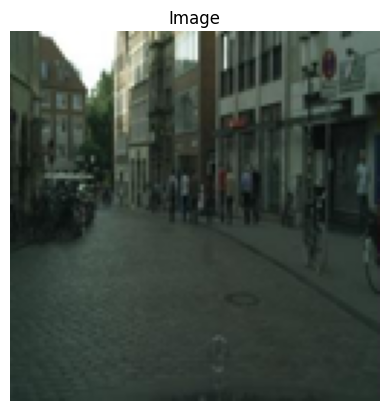

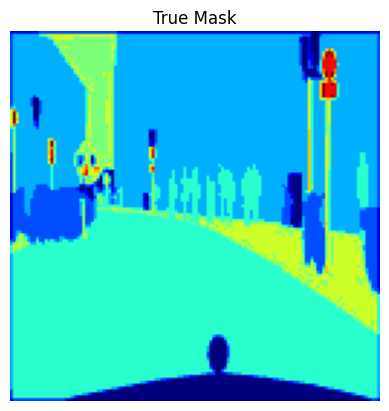

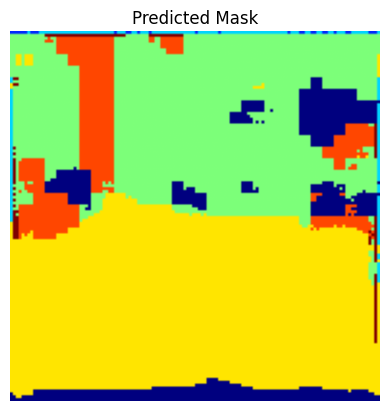

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model

BASE_DIR='cityscapes_data'
IMG_HEIGHT,IMG_WIDTH=128,128
NUM_CLASSES=13

def load_data(path):
    X,Y=[],[]
    bins=np.arange(20,260,20)
    for f in glob.glob(path+"/*.jpg"):
        img=Image.open(f)
        X.append(np.array(img.crop((0,0,256,256)).convert('RGB').resize((IMG_WIDTH,IMG_HEIGHT))))
        msk=img.crop((256,0,512,256)).convert('L').resize((IMG_WIDTH,IMG_HEIGHT))
        Y.append(np.digitize(np.array(msk),bins))
    return np.array(X,np.float32)/255.0,np.array(Y,np.int32)

def build_fcn(shape,classes):
    x=inputs=Input(shape)
    x=Conv2D(32,3,activation='relu',padding='same')(x)
    x=MaxPooling2D()(x)
    x=Conv2D(64,3,activation='relu',padding='same')(x)
    x=MaxPooling2D()(x)
    x=Conv2D(128,3,activation='relu',padding='same')(x)
    x=Conv2DTranspose(64,2,strides=2,padding='same')(x)
    x=Conv2DTranspose(32,2,strides=2,padding='same')(x)
    outputs=Conv2D(classes,1,activation='softmax')(x)
    return Model(inputs,outputs)

X_train,y_train=load_data(BASE_DIR+'/train')
X_val,y_val=load_data(BASE_DIR+'/val')

model=build_fcn((IMG_HEIGHT,IMG_WIDTH,3),NUM_CLASSES)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=8,epochs=2,validation_data=(X_val,y_val))

i=np.random.randint(len(X_val))
pred=np.argmax(model.predict(X_val[i:i+1]),-1)[0]

def show(title,img,cmap=None):
    plt.imshow(img,cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

show("Image",X_val[i])
show("True Mask",y_val[i],cmap='jet')
show("Predicted Mask",pred,cmap='jet')


In [ ]:
#3

In [11]:
import kagglehub

path = kagglehub.model_download("tensorflow/ssd-mobilenet-v2/tensorFlow2/ssd-mobilenet-v2")

print("Path to model files:", path)

Path to model files: C:\Users\yaswanth\.cache\kagglehub\models\tensorflow\ssd-mobilenet-v2\tensorFlow2\ssd-mobilenet-v2\1


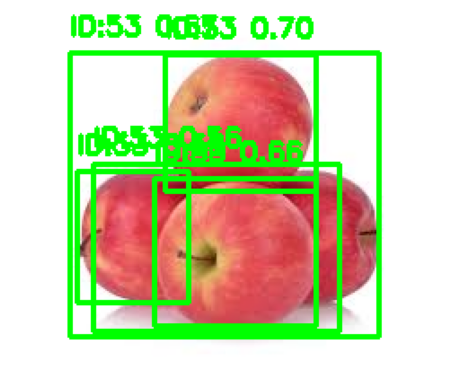

[{'class_id': 53, 'score': 0.6963353753089905, 'box': [86, 25, 170, 101]}, {'class_id': 53, 'score': 0.6653999090194702, 'box': [33, 24, 205, 182]}, {'class_id': 53, 'score': 0.660834014415741, 'box': [80, 94, 170, 176]}, {'class_id': 53, 'score': 0.5619587302207947, 'box': [46, 86, 183, 179]}, {'class_id': 53, 'score': 0.55400550365448, 'box': [37, 90, 99, 163]}]


In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2,matplotlib.pyplot as plt
#r"C:\Users\admin\.cache\kagglehub\models\tensorflow\ssd-mobilenet-v2\tensorFlow2\ssd-mobilenet-v2\1"
model_path=r"C:\Users\yaswanth\.cache\kagglehub\models\tensorflow\ssd-mobilenet-v2\tensorFlow2\ssd-mobilenet-v2\1"
detector=hub.load(model_path)

def detect_objects(image_path):
    img=cv2.imread(image_path)
    img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_resized=tf.image.resize(img_rgb,(320,320))
    img_resized=tf.cast(img_resized,tf.uint8)
    result=detector(tf.expand_dims(img_resized,0))
    result={k:v.numpy() for k,v in result.items()}
    objs=[]
    h,w=img.shape[:2]
    for b,s,c in zip(result["detection_boxes"][0],result["detection_scores"][0],result["detection_classes"][0]):
        if s>0.5:
            y1,x1,y2,x2=b
            x1,y1,x2,y2=int(x1*w),int(y1*h),int(x2*w),int(y2*h)
            objs.append({'class_id':int(c),'score':float(s),'box':[x1,y1,x2,y2]})
            cv2.rectangle(img_rgb,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(img_rgb,f"ID:{int(c)} {s:.2f}",(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
    return img_rgb,objs

image_path="sample.jpeg"
img_with_boxes,detected=detect_objects(image_path)
plt.imshow(img_with_boxes)
plt.axis("off")
plt.show()
print(detected)


In [ ]:
#2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

def load_img(files):
    return np.array([np.array(Image.open(f).convert('RGB').resize((64,64))) for f in files])

mel_files = glob('E:/Xai_Req_Setup/.../melanoma/*/*.*')
notmel_files = glob('E:/Xai_Req_Setup/.../notmelanoma/*/*.*')

X = np.concatenate([load_img(mel_files), load_img(notmel_files)])
y = np.concatenate([np.ones(len(mel_files)), np.zeros(len(notmel_files))])
X_train,X_test,y_train,y_test=train_test_split(X/255.0,y,test_size=0.2,random_state=42)

X_train_flat,X_test_flat=X_train.reshape(len(X_train),-1),X_test.reshape(len(X_test),-1)

dnn=models.Sequential([
    layers.Dense(256,activation='relu',input_shape=(64*64*3,)),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
dnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
dnn.fit(X_train_flat,y_train,epochs=10,batch_size=32,validation_split=0.2,verbose=0)
dnn_res=dnn.evaluate(X_test_flat,y_test,verbose=0)

cnn=models.Sequential([
    layers.Conv2D(16,3,activation='relu',input_shape=(64,64,3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
cnn.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2,verbose=0)
cnn_res=cnn.evaluate(X_test,y_test,verbose=0)

print("\n===== Model Comparison =====")
print(f"DNN - Loss: {dnn_res[0]:.4f}, Acc: {dnn_res[1]*100:.2f}%")
print(f"CNN - Loss: {cnn_res[0]:.4f}, Acc: {cnn_res[1]*100:.2f}%")


In [ ]:
#1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

load_img=lambda files:np.array([np.array(Image.open(f).convert('RGB').resize((64,64))) for f in files])
X=np.concatenate([
    load_img(glob('E:/Xai_Req_Setup/Yashwanth 126156184/Skin_Image_Dataset/*/Skin*/skin_data/melanoma/*/*.*')),
    load_img(glob('E:/Xai_Req_Setup/Yashwanth 126156184/Skin_Image_Dataset/*/Skin*/skin_data/notmelanoma/*/*.*'))
])
y=np.concatenate([np.ones(len(X)//2),np.zeros(len(X)//2)])
X_train,X_test,y_train,y_test=train_test_split(X/255.0,y,test_size=0.2,random_state=42)

def create_model(opt):
    m=models.Sequential([
        layers.Conv2D(16,3,activation='relu',input_shape=(64,64,3)),layers.MaxPooling2D(2),
        layers.Conv2D(32,3,activation='relu'),layers.MaxPooling2D(2),
        layers.Flatten(),layers.Dense(64,activation='relu'),
        layers.Dense(1,activation='sigmoid')
    ])
    m.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return m

model_sgd=create_model(optimizers.SGD(0.01))
history_sgd=model_sgd.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2,verbose=0)

model_adam=create_model('adam')
history_adam=model_adam.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2,verbose=0)

plt.plot(history_sgd.history['accuracy'],label='SGD Train')
plt.plot(history_adam.history['accuracy'],label='Adam Train')
plt.title('Training Accuracy');plt.xlabel('Epoch');plt.ylabel('Accuracy')
plt.legend();plt.grid();plt.show()

plt.plot(history_sgd.history['val_accuracy'],label='SGD Val')
plt.plot(history_adam.history['val_accuracy'],label='Adam Val')
plt.title('Validation Accuracy');plt.xlabel('Epoch');plt.ylabel('Accuracy')
plt.legend();plt.grid();plt.show()

def evaluate(m,h,name):
    print(f"\n{name} Evaluation:")
    acc=m.evaluate(X_test,y_test,verbose=0)[1]*100
    print(f"Test Accuracy: {acc:.2f}%")
    y_pred=(m.predict(X_test)>0.5).astype(int)
    print(classification_report(y_test,y_pred))
    plt.plot(h.history['accuracy'],label='Train')
    plt.plot(h.history['val_accuracy'],label='Val')
    plt.title(f'{name} Accuracy');plt.xlabel('Epoch');plt.ylabel('Accuracy')
    plt.legend();plt.grid();plt.show()

evaluate(model_sgd,history_sgd,"SGD Model")
evaluate(model_adam,history_adam,"Adam Model")
